In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [5]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv") ### стационарный
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv") ### нестационарный 
all_series = {
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Daily total female births in California": female_births["Count"]
}

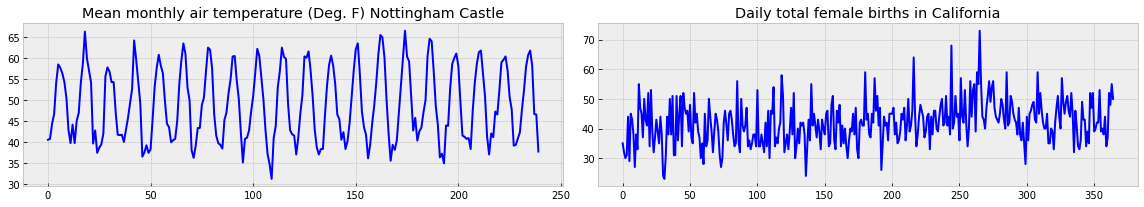

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

### Mean monthly air temperature (Deg. F) Nottingham Castle
#### Есть чёткая сезонность , нет выбросов , мало шума, я выбрал тройное экспоненциальное сглаживание ( Метод Хольта-Винтерса)


In [7]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp["Deg"], ser_to_plot=mean_monthly_temp["Deg"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

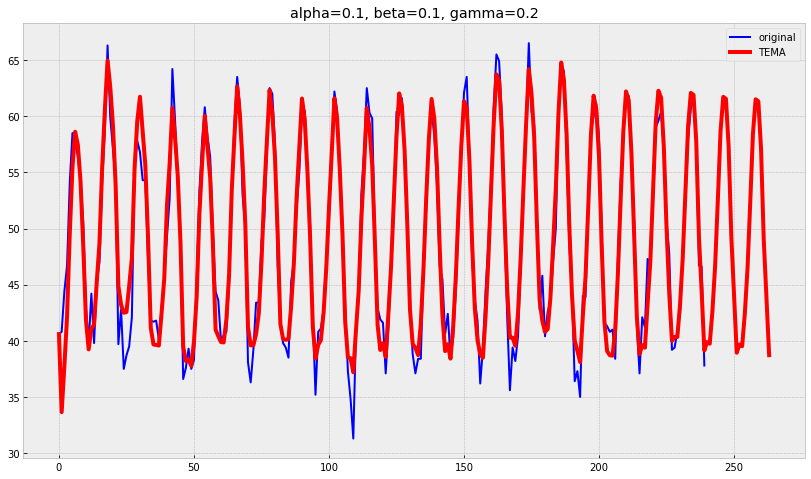

In [8]:
plot_tema(0.1, 0.1, 0.2)

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

series = mean_monthly_temp["Deg"]
train, val = series[:200], series[200:]

In [22]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

B:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


92.43717749646042------------
88.532804156941------------
92.43717749646038------------
92.10469172530868------------
89.56021032164726------------
87.81357703950039------------
85.71355535387654------------
83.95406670624423------------
80.28108592890625------------
80.51015939497432------------
76.62560449230787------------
71.9197936444936------------
70.24919967973713------------
64.31844941871655------------
64.19564514018126------------
58.14126571046177------------
54.642742325762356------------
48.7794728892704------------
45.947168455978435------------
40.22294457443404------------
40.378407213579855------------
40.701834249187165------------
37.27947420479505------------
39.02572541088953------------
37.58033732761179------------
34.081739511939695------------
31.45085849925881------------
32.00571115683348------------
36.26253962768741------------
27.80574067266792------------
23.861700248295037------------
25.6960136577014------------
21.591018294027293------------
18.19792

In [23]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.0845895 ,  0.00295036, -0.11439509],
       [ 0.08467483,  0.00295245, -0.11436421],
       [ 0.08456953,  0.00295338, -0.1143691 ],
       [ 0.08467914,  0.00295203, -0.11441867]]), array([5.96015164, 5.96015173, 5.96015202, 5.96015246]))
           fun: 5.960151639197151
       message: 'Optimization terminated successfully.'
          nfev: 255
           nit: 145
        status: 0
       success: True
             x: array([ 0.0845895 ,  0.00295036, -0.11439509])


В общем неплохо

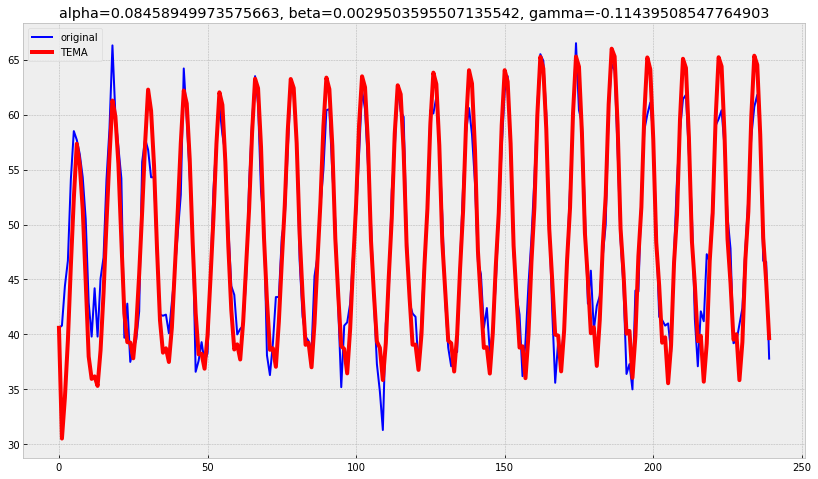

In [24]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

### Daily total female births in California
#### Нет сезонности , есть выбросы , много шума, я выбрал я выбрал двойное экспоненциальное сглаживание.

In [16]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [19]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

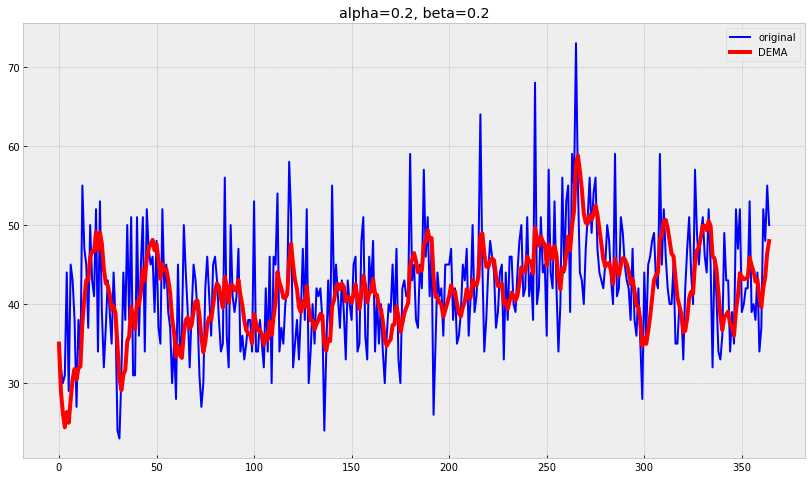

In [20]:
plot_dema(0.2, 0.2)

In [28]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = double_ema(series, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

series = female_births["Count"]
train, val = series[:300], series[300:]

In [29]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

B:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


987092.9111111112------------
909019.380870887------------
987092.9111111112------------
987092.9111111112------------
933253.9738192806------------
902084.1297575288------------
865409.1915203024------------
825096.0783098178------------
757252.676266635------------
765035.3342034271------------
703863.9889975097------------
632766.3732749508------------
596885.014281069------------
509520.9881987351------------
510677.9164908592------------
437794.71040956065------------
382900.1656542819------------
347039.0724411337------------
291006.7078560269------------
317234.2889442242------------
319393.27299511805------------
274026.83722558804------------
277658.7948855124------------
278773.7308911763------------
226337.98004734106------------
190658.66348601622------------
204494.51221959887------------
227326.51702523333------------
142587.00301771317------------
98928.20931272097------------
131323.32600424657------------
81705.54142709011------------
49359.60393012835------------
3004

In [30]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.08675296,  0.0993133 , -0.0492588 ],
       [ 0.08679627,  0.09927167, -0.04927847],
       [ 0.08678986,  0.09922441, -0.04928152],
       [ 0.08680257,  0.0992216 , -0.04927965]]), array([55.53065541, 55.53065609, 55.53065716, 55.53065727]))
           fun: 55.530655407477354
       message: 'Optimization terminated successfully.'
          nfev: 146
           nit: 85
        status: 0
       success: True
             x: array([ 0.08675296,  0.0993133 , -0.0492588 ])


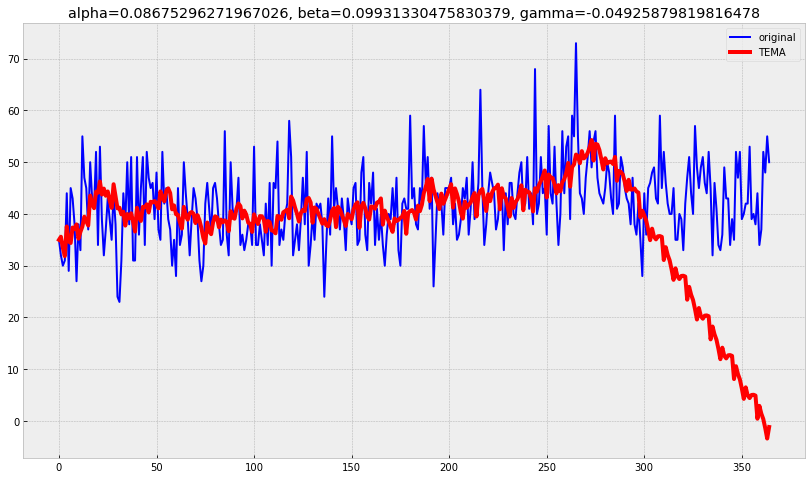

In [31]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

### Из-за нисходящего тренда в конце, предсказания не удались, сейчас попробую другой метод 

In [35]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

series = female_births["Count"]
train, val = series[:200], series[200:]

In [36]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

B:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


128.6944864004586------------
127.74050068465988------------
128.6944864004586------------
128.61617151920146------------
128.01009506714192------------
127.55457481029548------------
126.99493444927525------------
126.56935146389783------------
125.58353601409874------------
125.53455600499142------------
124.32933526824426------------
123.6203587476253------------
121.72180347163578------------
120.91326936755205------------
118.20495156773329------------
117.46011282752659------------
113.98440351824308------------
112.57146882479371------------
108.39462835101521------------
106.70756761572481------------
102.02841996485115------------
100.80783202771103------------
97.01608400803451------------
96.64126273411436------------
95.95988149593437------------
94.80200266880554------------
96.79082802749788------------
97.428210784147------------
95.75648360768326------------
98.49517933109273------------
95.25661309689089------------
94.15447137000126------------
93.27982117202374------

In [37]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[ 0.10195632,  0.00766074, -0.06962443],
       [ 0.10191981,  0.00766758, -0.06967417],
       [ 0.10188621,  0.00766692, -0.06963213],
       [ 0.10192556,  0.00767048, -0.0695963 ]]), array([67.03834564, 67.03834575, 67.03834593, 67.03834604]))
           fun: 67.03834564138256
       message: 'Optimization terminated successfully.'
          nfev: 162
           nit: 90
        status: 0
       success: True
             x: array([ 0.10195632,  0.00766074, -0.06962443])


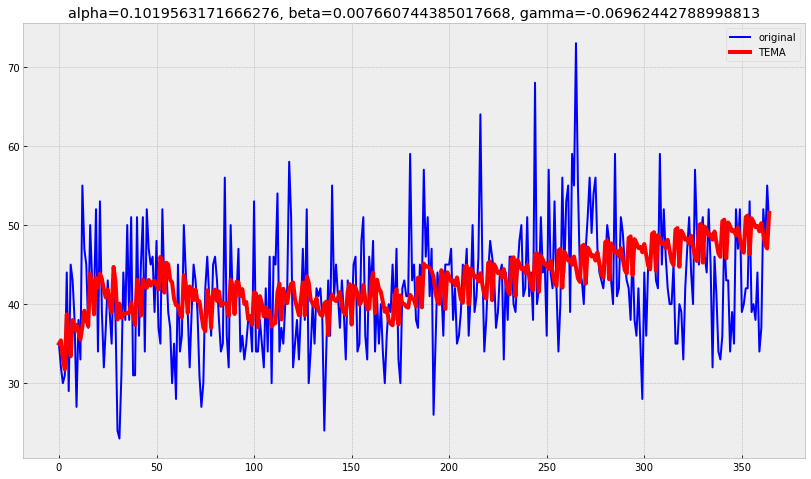

In [38]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

### Ну.... здесь тоже так себе получилось , но концепцию более менее отражает

### Спасибо за проверку! 